In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df = pd.read_csv('COP_data_final.csv', sep=';', decimal=',')

df['T_sup_HP'] = df['T_sup_HP'] + 273
df['T_OA'] = df['T_OA'] + 273
df['COP_real'] = 1/df['COP_real']

# Get the position of NaN values and remove the rows
df = df.replace('NaN', np.nan)
NaN_index = np.where(df['COP_real'].isna())[0]
df = df.dropna().reset_index()
df_regression = df

df

,index,T_OA,T_sup_HP,COP_real,Q_HP_real,W_HP,m_HP
0,0,248,303,0.480769,9.25,4.45,0.67
1,1,253,303,0.442478,10.63,4.70,0.67
2,2,258,303,0.408163,12.00,4.90,0.67
3,3,266,303,0.320513,14.00,4.49,0.67
4,4,269,303,0.303030,14.00,4.24,0.67
...,...,...,...,...,...,...,...
81,91,280,338,0.400000,14.00,5.60,0.34
82,92,283,338,0.377358,14.00,5.28,0.34
83,93,288,338,0.344828,14.00,4.83,0.34
84,94,291,338,0.327869,14.00,4.59,0.34


# Predicting COP with a linear model

In [2]:
# Declare the model
mod = smf.ols(formula='COP_real ~ T_OA', data=df_regression)

# Fit the model (finds the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2) 
res = mod.fit()

# Print the summary output
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               COP_real   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     220.4
Date:                Wed, 07 Feb 2024   Prob (F-statistic):           3.32e-25
Time:                        13:38:44   Log-Likelihood:                 107.91
No. Observations:                  86   AIC:                            -211.8
Df Residuals:                      84   BIC:                            -206.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6959      0.158     17.024      0.0

In [3]:
def cop(outT):
    return res.params.Intercept + res.params.T_OA*outT

# Get all the predicted COPs in a list
COP_list = []
for i in range(len(df['T_OA'])):
    COP_list.append(round(cop(df['T_OA'][i]),2))
    #else: COP_list.append(14)

# Get a list of all the real COPs
COP_list_real = list(df.COP_real)

# Compare with the real COPs
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(COP_list_real, COP_list)
print("MSE = {}".format(round(mse,3)))
print("sqrt(MSE) = {}".format(round(np.sqrt(mse)/np.mean(df.COP_real),3)))

print("\nIntercept: {}".format(res.params.Intercept))
print("T_OA coeff: {}".format(res.params.T_OA))

MSE = 0.005
sqrt(MSE) = 0.199

Intercept: 2.695868068327939
T_OA coeff: -0.008532993681728315


In [4]:
print(round(cop(273-2),4))

0.3834


In [5]:
df = pd.read_csv('COP_data_final.csv', sep=';', decimal=',')
df['COP_pred'] = 0
df['COP_real'] = 1/df['COP_real']

j = 0
for i in range(len(df.COP_real)):    
    if i in NaN_index:
        df['COP_pred'].iloc[i] = np.nan
    else:
        df['COP_pred'].iloc[i] = COP_list[j]
        j = j+1
        
df = df.fillna(0)

/Users/thomasdefauw/miniconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


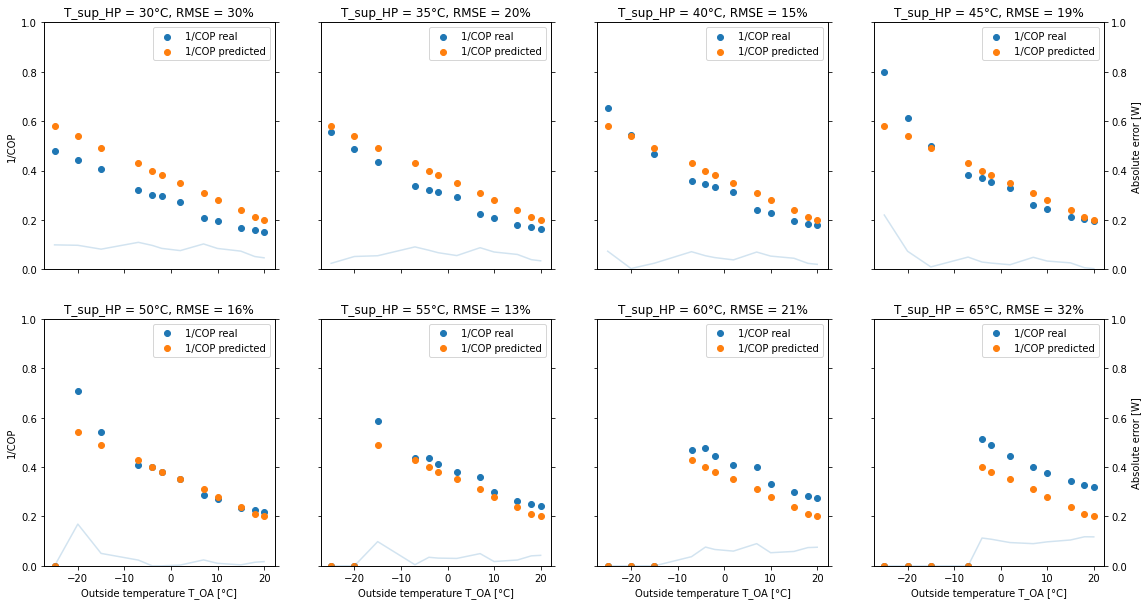

In [6]:
 # Creating a 2x4 (2 height, 4 width) grid of plots
fig, ax = plt.subplots(2,4, figsize=(19,10), sharex=True, sharey=True)

for i in range(2):
    for j in range(4):
        
        # This is the trick: i*width + j
        k = i*4 + j
        begin = k*12
        end = (k+1)*12
        
        # Plot the real and predicted 1/COP curves
        ax[i,j].scatter(df.T_OA[begin:end], df.COP_real[begin:end], label="1/COP real")
        ax[i,j].scatter(df.T_OA[begin:end], df.COP_pred[begin:end], label="1/COP predicted")
        
        # Set titles and labels
        mse_k = mean_squared_error(df.COP_real[begin:end], df.COP_pred[begin:end])
        ax[i,j].set_title("T_sup_HP = {}°C, RMSE = {}%".format(df.T_sup_HP[begin+2], round(100*np.sqrt(mse_k)/np.mean(df.COP_real[begin:end]))))
        if i==1: ax[i,j].set_xlabel("Outside temperature T_OA [°C]")
        if j==0: ax[i,j].set_ylabel("1/COP")
        ax[i,j].legend()
        ax[i,j].set_ylim(0,1)
        
        # Plot the absolute error
        ax2 = ax[i,j].twinx()
        ax2.plot(df.T_OA[begin:end], abs(df.COP_real[begin:end] - df.COP_pred[begin:end]), alpha=0.2)
        ax2.set_ylim(0,1)
        if j==3: ax2.set_ylabel("Absolute error [W]")
        if j!=3: ax2.set_yticklabels([])
        
plt.savefig('/Users/thomasdefauw/Desktop/sine_wave.jpg', dpi=300)
plt.show()
